# Scientific Data Analysis
Jasper Wink, 14616513 \
Dennis van der Werff, ...

# Imports

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import VAR


In [49]:
# Read data
cn = pd.read_csv("data/cryptonews.csv")
bp = pd.read_csv("data/btc.csv")

Group the data for each month. \
Determine the amount of articles for each month. \
Determine the mean opening bitcoin price for each month.

In [50]:
# Convert the date to the datetime format
cn['date'] = pd.to_datetime(cn['date'], format='%Y-%m-%d %H:%M:%S')
bp['date'] = pd.to_datetime(bp['Date'], format='%Y-%m-%d')

# Discard unnecairy date data, eg. hours, minutes etc
cn['weeks'] = cn['date'].dt.to_period('W')
bp['weeks'] = bp['date'].dt.to_period('W')

# Extract the polarity field out of the cn dataset
cn['sentiment'] = cn['sentiment'].apply(ast.literal_eval)
cn['polarity'] = cn['sentiment'].apply(lambda x: x['polarity'])

# Group data by the weeks
bp_weekly_mean = bp.groupby('weeks')['Open'].mean().reset_index(name='Open_mean')
cn_weekly_count = cn.groupby('weeks').size().reset_index(name='Count')
cn_weekly_sentiment = cn.groupby('weeks')['polarity'].mean().reset_index(name='polarity_mean')


# Data visualisation

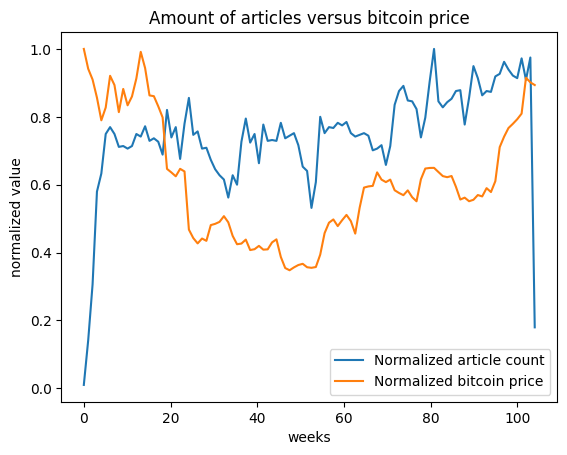

In [41]:
# Normalize the data
cn_count_list = list(cn_weekly_count['Count'])
normalized_count = [count / max(cn_count_list) for count in cn_count_list]

bp_mean_list = list(bp_weekly_mean['Open_mean'])
normalized_mean = [mean / max(bp_mean_list) for mean in bp_mean_list]


# Plot the data
x = np.linspace(0, len(normalized_count), len(normalized_count))
plt.plot(x, normalized_count, label='Normalized article count')
plt.plot(x, normalized_mean, label='Normalized bitcoin price')
plt.title('Amount of articles versus bitcoin price')
plt.xlabel('weeks')
plt.ylabel('normalized value')
plt.legend()
plt.show()

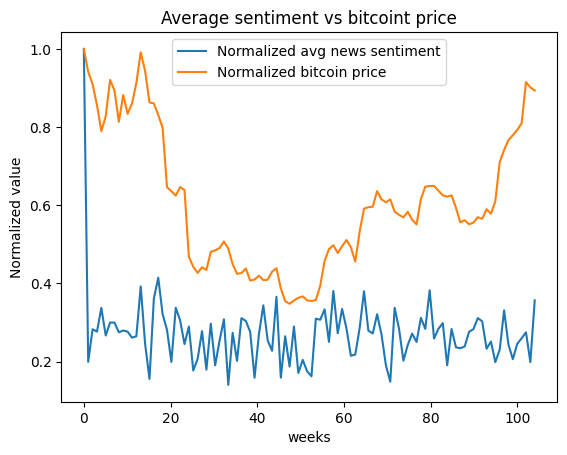

In [40]:
nr_sentiment_data = len(cn_weekly_sentiment['polarity_mean'])
cn_sentiment_list = list(cn_weekly_sentiment['polarity_mean'])
normalized_sentiment = [sentiment / max(cn_sentiment_list)
                        for sentiment in cn_sentiment_list]

# Plot the data
x = np.linspace(0, nr_sentiment_data, nr_sentiment_data)
plt.plot(x, normalized_sentiment,
         label='Normalized avg news sentiment')
plt.plot(x, normalized_mean, label='Normalized bitcoin price')
plt.title('Average sentiment vs bitcoint price')
plt.xlabel('weeks')
plt.ylabel('Normalized value')
plt.legend()
plt.show()

# Spearman Correlation
To be able to detect whether there is correlation between the bitcoin price and the amount of news articles and the bitcoin price and the average news sentiment we will be using spearman correlation.

In [43]:
# https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient
def spearman_correlation(rank1, rank2):
    n = len(rank1)

    sum_d_squared = sum([(rank1[i] - rank2[i])**2 for i in range(n)])
    correlation = 1 - ((6 * sum_d_squared) / (n * (n**2 - 1)))
    return correlation


# Calculate ranks
bp_mean_rank = list(bp_weekly_mean['Open_mean'].rank())
cn_count_rank = list(cn_weekly_count['Count'].rank())
cn_sentiment_rank = list(cn_weekly_sentiment['polarity_mean'].rank())

correlation = spearman_correlation(cn_count_rank, bp_mean_rank)
print('Article count vs bitcoin price.')
print(f'Spearman Correlation: {correlation:.3f}\n')

correlation = spearman_correlation(cn_sentiment_rank, bp_mean_rank)
print('Sentiment vs bitcoin price.')
print(f'Spearman Correlation: {correlation:.3f}')


Article count vs bitcoin price.
Spearman Correlation: 0.130

Sentiment vs bitcoin price.
Spearman Correlation: 0.219


# Stationary test

Using the Augmented Dickey-Fuller (ADF) test to check if the current data is satationary. If the p-value scores lower than 0.05 we reject the $H_0$ and determine that the data is stationary.

In [59]:
ad_fuller_result_1 = adfuller(bp_weekly_mean['Open_mean'].diff().dropna())
print(f'p-value: {ad_fuller_result_1[1]} (Bitcoint price)')

ad_fuller_result_2 = adfuller(cn_weekly_count['Count'])
print(f'p-value: {ad_fuller_result_2[1]} (Article count)')

ad_fuller_result_3 = adfuller(cn_weekly_sentiment['polarity_mean'])
print(f'p-value: {ad_fuller_result_3[1]} (News sentiment)')


p-value: 4.4567176804253537e-13 (Bitcoint price)
p-value: 4.5240581131031196e-05 (Article count)
p-value: 1.3517752025053774e-29 (News sentiment)


# Vector auto regression

Firstly we determine how manny lags we want to use for the mean opening bitcoin price using the pacf. We see in the plot that we need to use a lag of 1.

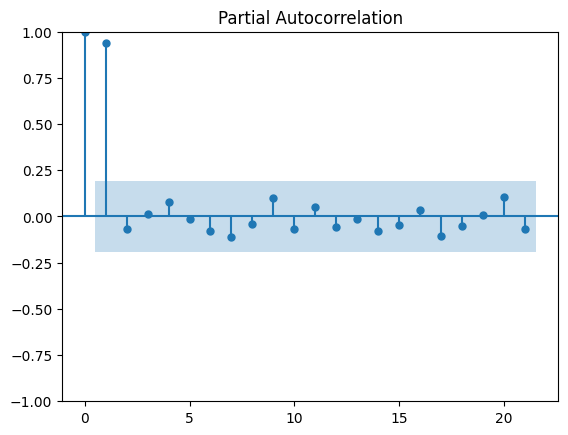

In [57]:
plot_pacf(bp_weekly_mean['Open_mean'])
plt.show()

In [73]:
count_price_merge = pd.merge(cn_weekly_count, bp_weekly_mean, on='weeks', how='inner')
print(count_price_merge.head())


                   weeks  Count     Open_mean
0  2021-12-27/2022-01-02      4  46996.300000
1  2022-01-03/2022-01-09     56  44245.300000
2  2022-01-10/2022-01-16    121  42755.914286
3  2022-01-17/2022-01-23    229  40243.542857
4  2022-01-24/2022-01-30    250  37111.985714


In [72]:
granger_1 = grangercausalitytests(count_price_merge[['Count', 'Open_mean']], 10)
print(granger_1)

granger_2 = grangercausalitytests(count_price_merge[['Open_mean', 'Count']], 10)
print(granger_2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0511  , p=0.8216  , df_denom=100, df_num=1
ssr based chi2 test:   chi2=0.0526  , p=0.8186  , df=1
likelihood ratio test: chi2=0.0526  , p=0.8186  , df=1
parameter F test:         F=0.0511  , p=0.8216  , df_denom=100, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3786  , p=0.2568  , df_denom=97, df_num=2
ssr based chi2 test:   chi2=2.8993  , p=0.2346  , df=2
likelihood ratio test: chi2=2.8589  , p=0.2394  , df=2
parameter F test:         F=1.3786  , p=0.2568  , df_denom=97, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4691  , p=0.0667  , df_denom=94, df_num=3
ssr based chi2 test:   chi2=7.9589  , p=0.0469  , df=3
likelihood ratio test: chi2=7.6609  , p=0.0536  , df=3
parameter F test:         F=2.4691  , p=0.0667  , df_denom=94, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8718  , p=0.1221  , df